##**Практическое задание 4**

In [10]:
%%writefile practice4.cu
#include <iostream>   // для вывода в консоль (cout)
#include <vector>     // для работы с массивами на CPU
#include <random>     // для генерации случайных чисел
#include <cuda_runtime.h> // CUDA API (kernel-и, память, события)
#include <iomanip>    // для красивого табличного вывода

using namespace std;

// Макрос: проверка ошибок CUDA-вызовов (если ошибка - печатаем и завершаем программу)
#define CUDA_CHECK(x) do { \
  cudaError_t e = (x); \
  if (e != cudaSuccess) { \
    cout << "CUDA error: " << cudaGetErrorString(e) \
         << " at " << __FILE__ << ":" << __LINE__ << "\n"; \
    exit(1); \
  } \
} while(0)

// Базовые параметры программы
static const int BLOCK = 256;  // стандартный размер блока потоков для kernel-ов
static const int CHUNK = 256;  // размер маленьких подмассивов (чанков) для пузырьковой сортировки


// Универсальная функция-таймер на CUDA events
// Она принимает "launch" - лямбду, внутри которой мы запускаем нужные kernel-ы
// Мы измеряем только время выполнения kernel, без копирования памяти

template <typename Launch>
float timeKernel(Launch launch) {
    cudaEvent_t evStart, evStop;

    // Создаём события начала и конца измерения
    CUDA_CHECK(cudaEventCreate(&evStart));
    CUDA_CHECK(cudaEventCreate(&evStop));

    // Записываем время начала
    CUDA_CHECK(cudaEventRecord(evStart));

    // Запускаем переданные kernel-и
    launch();

    // Записываем время окончания
    CUDA_CHECK(cudaEventRecord(evStop));

    // Ждём, пока всё реально выполнится на GPU
    CUDA_CHECK(cudaEventSynchronize(evStop));

    // Считаем разницу во времени
    float ms = 0.0f;
    CUDA_CHECK(cudaEventElapsedTime(&ms, evStart, evStop));

    // Освобождаем события
    CUDA_CHECK(cudaEventDestroy(evStart));
    CUDA_CHECK(cudaEventDestroy(evStop));

    return ms; // возвращаем время выполнения в миллисекундах
}

// Task 2: Reduction

// Редукция только через глобальную память
// Каждый поток берёт свой элемент и сразу делает atomicAdd в одну общую сумму
// Просто, но медленно, потому что все потоки "дерутся" за одну ячейку памяти

__global__ void reduce_global_only(const float* in, float* sum, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x; // глобальный индекс элемента
    if (i < N) {
        atomicAdd(sum, in[i]); // добавляем элемент в общую сумму (атомарно)
    }
}

// Редукция с использованием глобальной + разделяемой памяти
// Каждый блок сначала суммирует свои элементы внутри shared memory
// Потом только один поток от блока делает atomicAdd в глобальную сумму
// Это сильно уменьшает число атомарных операций

__global__ void reduce_shared(const float* in, float* sum, int N) {
    __shared__ float s[BLOCK]; // shared memory на уровне блока

    int tid = threadIdx.x; // номер потока внутри блока
    int i   = blockIdx.x * blockDim.x + tid; // глобальный индекс элемента

    // Загружаем данные в shared memory (или 0, если вышли за границы)
    s[tid] = (i < N) ? in[i] : 0.0f;
    __syncthreads(); // ждём, пока все потоки загрузят данные

    // Классическая параллельная редукция в shared memory
    for (int stride = blockDim.x / 2; stride > 0; stride >>= 1) {
        if (tid < stride) {
            s[tid] += s[tid + stride]; // складываем пары элементов
        }
        __syncthreads(); // синхронизация после каждого шага
    }

    // Только поток 0 записывает результат блока в глобальную сумму
    if (tid == 0) {
        atomicAdd(sum, s[0]);
    }
}

// Task 3: Sort pipeline

// Пузырьковая сортировка маленьких чанков
// Каждый блок сортирует свой кусок массива размером CHUNK

__global__ void bubble_chunks(float* a, int N) {

    // Shared memory для хранения одного чанка
    __shared__ float s[CHUNK];

    // Начало текущего чанка в глобальном массиве
    int base = blockIdx.x * CHUNK;

    // Локальный индекс потока внутри блока
    int tid = threadIdx.x;

    // Глобальный индекс элемента
    int idx = base + tid;

    // Загружаем данные в shared memory
    // Если вышли за границы, кладём очень большое число (padding)
    s[tid] = (idx < N) ? a[idx] : 1e30f;

    // Синхронизация потоков блока
    __syncthreads();

    // Пузырьковую сортировку выполняет только поток 0
    if (tid == 0) {
        for (int i = 0; i < CHUNK - 1; i++) {
            for (int j = 0; j < CHUNK - 1 - i; j++) {
                if (s[j] > s[j + 1]) {
                    float t = s[j];
                    s[j] = s[j + 1];
                    s[j + 1] = t;
                }
            }
        }
    }

    // Ждём завершения сортировки
    __syncthreads();

    // Записываем отсортированный чанк обратно в глобальную память
    if (idx < N) {
        a[idx] = s[tid];
    }
}

// Вспомогательная функция: бинарный поиск (lower_bound) внутри shared memory
// Нужна для корректного слияния двух отсортированных сегментов
__device__ __forceinline__ int lowerBoundShared(const float* R, int n, float x) {
    int lo = 0, hi = n;
    while (lo < hi) {
        int mid = (lo + hi) >> 1;
        if (R[mid] < x) lo = mid + 1;
        else hi = mid;
    }
    return lo;
}

// Kernel для слияния двух отсортированных сегментов длины width
// Мы загружаем оба сегмента в shared memory,
// а потом параллельно формируем отсортированный результат

__global__ void merge_pass(const float* in, float* out, int N, int width) {
    int base = blockIdx.x * (2 * width); // начало пары сегментов
    int tid  = threadIdx.x;              // номер потока в блоке

    int m = max(0, min(width, N - base));          // реальный размер левого сегмента
    int n = max(0, min(width, N - (base + width))); // реальный размер правого сегмента
    int outLen = m + n; // длина результата слияния

    extern __shared__ float sh[];
    float* L = sh;           // левый сегмент в shared memory
    float* R = sh + width;   // правый сегмент в shared memory

    // Загружаем L и R в shared memory
    for (int i = tid; i < width; i += blockDim.x) {
        L[i] = (i < m) ? in[base + i] : 1e30f;
        R[i] = (i < n) ? in[base + width + i] : 1e30f;
    }
    __syncthreads();

    // Каждый поток пишет несколько элементов результата
for (int k = tid; k < outLen; k += blockDim.x) {
    // Цикл распределяет работу между потоками блока:
    // каждый поток обрабатывает позиции k, k+blockDim.x, k+2*blockDim.x и т.д.

    int iGuess = min(k, m);
    // Берём начальное предположение, сколько элементов взять из левого массива L

    float a = (iGuess < m) ? L[iGuess] : 1e30f;
    // Если iGuess внутри левого массива, берем L[iGuess],
    // иначе ставим очень большое число как padding

    int j = lowerBoundShared(R, n, a);
    // В правом массиве R ищем позицию, где элементы становятся больше a
    // Это бинарный поиск в shared memory

    int i = k - j;
    // Определяем, сколько элементов нужно взять из L, чтобы суммарно получилось k

    if (i < 0) i = 0;
    // Если получилось отрицательное значение, фиксируем его как 0

    if (i > m) i = m;
    // Если получилось больше размера L, ограничиваем максимумом m

    float lv = (i < m) ? L[i] : 1e30f;
    // Берём кандидата из левого массива (или большое число, если вышли за границы)

    float rv = (j < n) ? R[j] : 1e30f;
    // Берём кандидата из правого массива (или большое число, если вышли за границы)

    out[base + k] = (lv <= rv) ? lv : rv;
    // Записываем в итоговый массив меньший из двух кандидатов
}
// Конец цикла параллельного слияния
}


// Запуск редукции только через глобальную память
float runReduceGlobal(const float* dIn, int N) {

    float* dSum = nullptr;
    // Указатель на переменную-сумму на GPU

    CUDA_CHECK(cudaMalloc(&dSum, sizeof(float)));
    // Выделяем память под одну переменную на GPU

    CUDA_CHECK(cudaMemset(dSum, 0, sizeof(float)));
    // Обнуляем сумму перед началом редукции

    dim3 block(BLOCK);
    // Задаём размер блока потоков

    dim3 grid((N + BLOCK - 1) / BLOCK);
    // Считаем количество блоков, чтобы покрыть весь массив

    float ms = timeKernel([&] {
        // Запускаем измерение времени выполнения kernel

        reduce_global_only<<<grid, block>>>(dIn, dSum, N);
        // Запускаем kernel редукции через глобальную память
    });

    CUDA_CHECK(cudaFree(dSum));
    // Освобождаем память на GPU

    return ms;
    // Возвращаем измеренное время
}

// Запуск редукции с shared memory
float runReduceShared(const float* dIn, int N) {

    float* dSum = nullptr;
    // Указатель на сумму на GPU

    CUDA_CHECK(cudaMalloc(&dSum, sizeof(float)));
    // Выделяем память под одну переменную

    CUDA_CHECK(cudaMemset(dSum, 0, sizeof(float)));
    // Обнуляем сумму перед запуском

    dim3 block(BLOCK);
    // Задаём размер блока потоков

    dim3 grid((N + BLOCK - 1) / BLOCK);
    // Считаем количество блоков

    float ms = timeKernel([&] {
        // Запускаем измерение времени

        reduce_shared<<<grid, block>>>(dIn, dSum, N);
        // Запускаем kernel редукции с использованием shared memory
    });

    CUDA_CHECK(cudaFree(dSum));
    // Освобождаем память на GPU

    return ms;
    // Возвращаем измеренное время
}

// Запуск всей сортировочной pipeline:
// 1. пузырёк по чанкам
// 2. последовательные слияния
float runSortPipeline(const vector<float>& h, int N) {

    float *dA = nullptr, *dB = nullptr;
    // Два массива на GPU: один для входа, второй как буфер

    CUDA_CHECK(cudaMalloc(&dA, N * sizeof(float)));
    // Выделяем память для первого массива

    CUDA_CHECK(cudaMalloc(&dB, N * sizeof(float)));
    // Выделяем память для буферного массива

    CUDA_CHECK(cudaMemcpy(dA, h.data(), N * sizeof(float), cudaMemcpyHostToDevice));
    // Копируем данные с CPU на GPU

    int numChunks = (N + CHUNK - 1) / CHUNK;
    // Считаем, сколько блоков (чанков) нам нужно для пузырьковой сортировки

    float ms = timeKernel([&] {
        // Начинаем измерение времени всей сортировочной pipeline

        bubble_chunks<<<numChunks, CHUNK>>>(dA, N);
        // Запускаем kernel пузырьковой сортировки по чанкам

        CUDA_CHECK(cudaDeviceSynchronize());
        // Ждём завершения сортировки чанков

        int width = CHUNK;
        // Начальный размер сегмента для слияния

        bool ping = true;
        // Флаг для переключения между dA и dB

        while (width < N) {
            // Повторяем слияние, пока не соберём весь массив

            size_t shmem = 2ULL * width * sizeof(float);
            // Считаем, сколько shared memory нужно для двух сегментов

            if (shmem > 48ULL * 1024ULL) break;
            // Если shared памяти слишком много, прекращаем

            int numPairs = (N + (2 * width) - 1) / (2 * width);
            // Считаем, сколько пар сегментов будем сливать

            const float* in  = ping ? dA : dB;
            // Определяем входной массив

            float* out       = ping ? dB : dA;
            // Определяем выходной массив

            merge_pass<<<numPairs, BLOCK, shmem>>>(in, out, N, width);
            // Запускаем kernel слияния

            CUDA_CHECK(cudaDeviceSynchronize());
            // Ждём завершения слияния

            ping = !ping;
            // Меняем местами вход и выход

            width *= 2;
            // Увеличиваем размер сегмента вдвое
        }
    });

    CUDA_CHECK(cudaFree(dA));
    // Освобождаем первый массив

    CUDA_CHECK(cudaFree(dB));
    // Освобождаем буферный массив

    return ms;
    // Возвращаем общее время сортировки
}

int main() {

    vector<int> sizes = {10000, 100000, 1000000};
    // Три размера массивов по заданию

    mt19937 gen(42);
    // Генератор случайных чисел с фиксированным сидом

    uniform_real_distribution<float> dist(0.0f, 100.0f);
    // Диапазон случайных чисел

    cout << "\nGPU Practical results\n";

    cout << left
         << setw(12) << "N"
         << setw(22) << "Reduce global (ms)"
         << setw(22) << "Reduce shared (ms)"
         << setw(20) << "Sort pipeline (ms)"
         << "\n";
    // Печатаем названия столбцов

    cout << fixed << setprecision(6);
    // Делаем вывод аккуратным с 6 знаками после запятой

    for (int N : sizes) {
        // Проходим по всем размерам массива

        vector<float> h(N);
        // Создаём массив на CPU

        for (int i = 0; i < N; i++) h[i] = dist(gen);
        // Заполняем его случайными числами

        float* dIn = nullptr;
        // Указатель на массив на GPU

        CUDA_CHECK(cudaMalloc(&dIn, N * sizeof(float)));
        // Выделяем память на GPU

        CUDA_CHECK(cudaMemcpy(dIn, h.data(), N * sizeof(float), cudaMemcpyHostToDevice));
        // Копируем данные на GPU

        float tRedGlobal = runReduceGlobal(dIn, N);
        // Замеряем время редукции через global memory

        float tRedShared = runReduceShared(dIn, N);
        // Замеряем время редукции через shared memory

        float tSort = runSortPipeline(h, N);
        // Замеряем время сортировочной pipeline

        CUDA_CHECK(cudaFree(dIn));
        // Освобождаем память на GPU

        cout << left
             << setw(12) << N
             << setw(22) << tRedGlobal
             << setw(22) << tRedShared
             << setw(20) << tSort
             << "\n";
        // Печатаем результаты в таблицу
    }

    return 0;
}


Overwriting practice4.cu


In [11]:
!nvcc -O3 -arch=sm_75 practice4.cu -o practice4
!./practice4


GPU Practical results
N           Reduce global (ms)    Reduce shared (ms)    Sort pipeline (ms)  
10000       0.167872              0.019872              1.878336            
100000      0.356352              0.016768              5.248032            
1000000     3.520160              0.106528              42.636097           


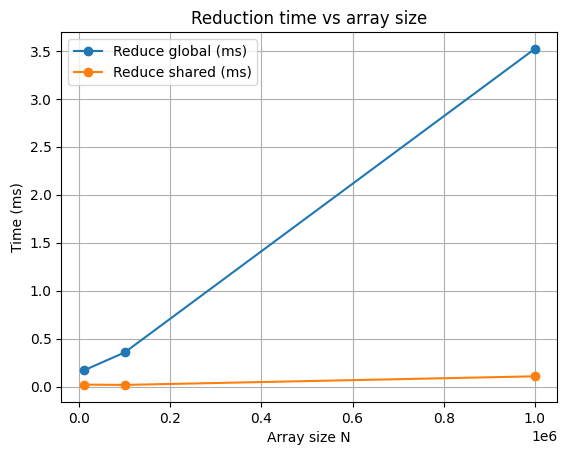

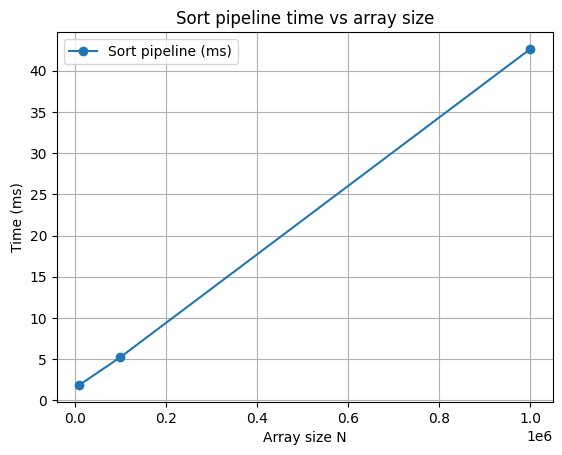

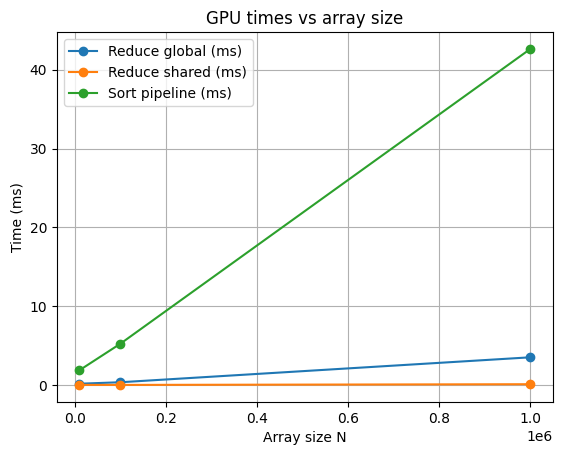

In [14]:
import matplotlib.pyplot as plt

# Данные из твоего вывода
N = [10_000, 100_000, 1_000_000]

reduce_global = [0.167872, 0.356352, 3.520160]
reduce_shared = [0.019872, 0.016768, 0.106528]
sort_pipeline = [1.878336, 5.248032, 42.636097]

# 1) График: редукции (global vs shared)
plt.figure()
plt.plot(N, reduce_global, marker='o', label='Reduce global (ms)')
plt.plot(N, reduce_shared, marker='o', label='Reduce shared (ms)')
plt.xlabel('Array size N')
plt.ylabel('Time (ms)')
plt.title('Reduction time vs array size')
plt.grid(True, which='both')
plt.legend()
plt.show()

# 2) График: сортировочный pipeline
plt.figure()
plt.plot(N, sort_pipeline, marker='o', label='Sort pipeline (ms)')
plt.xlabel('Array size N')
plt.ylabel('Time (ms)')
plt.title('Sort pipeline time vs array size')
plt.grid(True, which='both')
plt.legend()
plt.show()

# 3) Все три на одном графике
plt.figure()
plt.plot(N, reduce_global, marker='o', label='Reduce global (ms)')
plt.plot(N, reduce_shared, marker='o', label='Reduce shared (ms)')
plt.plot(N, sort_pipeline, marker='o', label='Sort pipeline (ms)')
plt.xlabel('Array size N')
plt.ylabel('Time (ms)')
plt.title('GPU times vs array size')
plt.grid(True, which='both')
plt.legend()
plt.show()

##**Вывод**

В ходе работы были реализованы и протестированы три GPU-алгоритма: редукция суммы с использованием только глобальной памяти, редукция с применением разделяемой памяти, а также сортировочный конвейер, включающий локальную сортировку подмассивов и их последующее слияние. Эксперименты проводились для массивов размером 10 000, 100 000 и 1 000 000 элементов.

Результаты показывают, что использование разделяемой памяти значительно ускоряет редукцию по сравнению с версией, основанной исключительно на глобальной памяти. Во всех случаях редукция с shared memory выполняется на порядок быстрее, что объясняется снижением количества медленных обращений к глобальной памяти и уменьшением нагрузки на атомарные операции.

Сортировочный конвейер ожидаемо занимает больше времени, особенно при увеличении размера массива, так как включает несколько этапов обработки, в том числе локальную сортировку и многократные операции слияния. При размере массива 1 000 000 элементов время сортировки возрастает существенно, что подтверждает высокую вычислительную сложность данной процедуры.

Таким образом, эксперимент демонстрирует, что грамотное использование разделяемой памяти может существенно повысить производительность CUDA-программ, особенно для задач редукции, тогда как сложные сортировочные алгоритмы требуют дополнительных оптимизаций для эффективного масштабирования на больших данных.